In [1]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np 
from matplotlib import style

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/Users/derrekgass/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/derrekgass/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/derrekgass/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/derrekgass/anaconda3/lib/python3.7

In [2]:
# Get the stock data using yahoo API:
style.use('ggplot')

# get 2014-2018 data to train our model
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2018,12,30)
df = web.DataReader("^GSPC", 'yahoo', start, end) 

# get 2019 data to test our model on 
start = datetime.datetime(2019,1,1)
end = datetime.date.today()
test_df = web.DataReader("^GSPC", 'yahoo', start, end) 

In [3]:
# sort by date
df = df.sort_values('Date')
test_df = test_df.sort_values('Date')

# fix the date 
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)
test_df.reset_index(inplace=True)
test_df.set_index("Date", inplace=True)

df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-24,2410.340088,2351.100098,2400.560059,2351.100098,2613930000,2351.100098
2018-12-26,2467.760010,2346.580078,2363.120117,2467.699951,4233990000,2467.699951
2018-12-27,2489.100098,2397.939941,2442.500000,2488.830078,4096610000,2488.830078
2018-12-28,2520.270020,2472.889893,2498.770020,2485.739990,3702620000,2485.739990
2018-12-31,2509.239990,2482.820068,2498.939941,2506.850098,3442870000,2506.850098


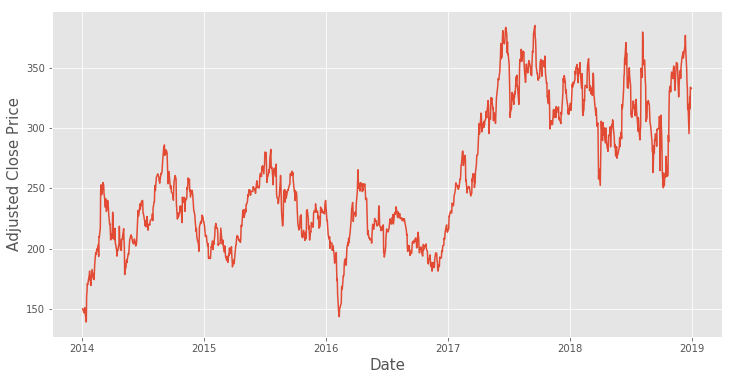

In [18]:
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(df["Adj Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Adjusted Close Price',fontsize=15)
plt.show()

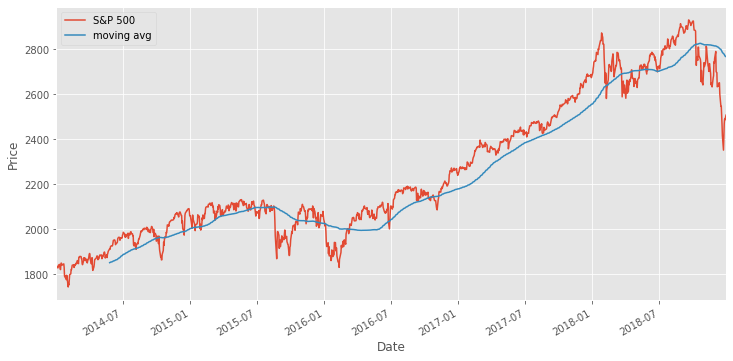

In [6]:
# Rolling mean
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='S&P 500')
mavg.plot(label='moving avg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [7]:
import matplotlib.dates as mdates

# change the dates into ints for training 
dates_df = df.copy()
dates_df = dates_df.reset_index()

# Store the original dates for plotting the predicitons
org_dates = dates_df['Date']

# convert to ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
1253,737052.0,2410.340088,2351.100098,2400.560059,2351.100098,2613930000,2351.100098
1254,737054.0,2467.760010,2346.580078,2363.120117,2467.699951,4233990000,2467.699951
1255,737055.0,2489.100098,2397.939941,2442.500000,2488.830078,4096610000,2488.830078
1256,737056.0,2520.270020,2472.889893,2498.770020,2485.739990,3702620000,2485.739990
1257,737059.0,2509.239990,2482.820068,2498.939941,2506.850098,3442870000,2506.850098


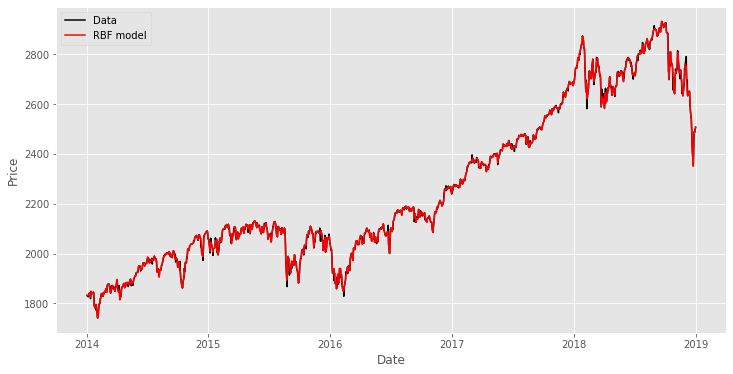

In [8]:
# Use sklearn support vector regression to predicit our data:
from sklearn.svm import SVR

dates = dates_df['Date'].as_matrix()
prices = df['Adj Close'].as_matrix()

#Convert to 1d Vector
dates = np.reshape(dates, (len(dates), 1))
prices = np.reshape(prices, (len(prices), 1))

svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(dates, prices)

plt.figure(figsize = (12,6))
plt.plot(dates, prices, color= 'black', label= 'Data')
plt.plot(org_dates, svr_rbf.predict(dates), color= 'red', label= 'RBF model') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [9]:
# Create train set of adj close prices data:
train_data = df.loc[:,'Adj Close'].as_matrix()
print(train_data.shape) # 1258 

(1258,)


In [10]:
# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

In [11]:
'''Function to create a dataset to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)

(1222, 36, 1)


In [13]:
# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

X_train:
[[1831.97998047]
 [1831.36999512]
 [1826.77001953]
 [1837.88000488]
 [1837.48999023]
 [1838.13000488]
 [1842.36999512]
 [1819.19995117]
 [1838.88000488]
 [1848.38000488]
 [1845.89001465]
 [1838.69995117]
 [1843.80004883]
 [1844.85998535]
 [1828.45996094]
 [1790.29003906]
 [1781.56005859]
 [1792.5       ]
 [1774.19995117]
 [1794.18994141]
 [1782.58996582]
 [1741.89001465]
 [1755.19995117]
 [1751.64001465]
 [1773.43005371]
 [1797.02001953]
 [1799.83996582]
 [1819.75      ]
 [1819.26000977]
 [1829.82995605]
 [1838.63000488]
 [1840.76000977]
 [1828.75      ]
 [1839.7800293 ]
 [1836.25      ]
 [1847.60998535]]


y_train: [[1845.11999512]]



In [14]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 855 samples, validate on 367 samples
Epoch 1/20
855/855 [==============================] - 29s 34ms/step - loss: 0.0055 - val_loss: 0.0022
Epoch 2/20
855/855 [==============================] - 22s 26ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 3/20
855/855 [==============================] - 22s 26ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 4/20
855/855 [==============================] - 23s 27ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 5/20
855/855 [==============================] - 23s 26ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 6/20
855/855 [==============================] - 22s 26ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 7/20
855/855 [==============================] - 23s 27ms/step - loss: 9.5708e-04 - val_loss: 0.0014
E

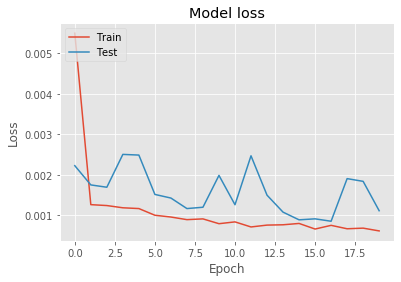

In [15]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
# Get the stock prices for 2019 to have our model make the predictions
test_data = test_df['Adj Close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)

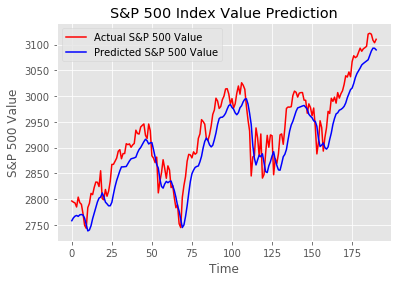

In [17]:
plt.plot(org_y, color = 'red', label = 'Actual S&P 500 Value')
plt.plot(predicted_y, color = 'blue', label = 'Predicted S&P 500 Value')
plt.title('S&P 500 Index Value Prediction')
plt.xlabel('Time')
plt.ylabel('S&P 500 Value')
plt.legend()
plt.show()